In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

# import compare_with_benchmark as bn
import my_simgraph_04 as sg
import data_handler_01 as dh

# Load spike data

Spike data shape:  (297, 1141, 113) $\implies$ (movie repeats, frames/time, neurons)
<br>
Labels are 1 (= spike) or -1 (= no spike).

In [2]:
# load all spike data from file
spikes_dp = '../../data/original_files/spikes.csv'
binned_data = np.loadtxt(spikes_dp, delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)
binned_data = binned_data * 2 - 1     # turn labels from 0,1 to -1,1

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

## Group all 113 neurons

This will create a more balanced dataset which is presumabley easier to solve.
<br>
Grouped data shape:  (297, 1141, 1) $\implies$ (movie repeats, frames/time, group)

In [3]:
# group all neurons together
grouped_data = np.zeros((297, 1141, 1))
for trial in range(297):
    for frame in range(1141):
        grouped_data[trial, frame, :] = 2 * int((binned_data[trial, frame, :] == 1).any()) - 1

In [4]:
# print some statistics
print('grouped_data.shape = ', grouped_data.shape)

avg_spike_perc = 0
print('trial #    | percentage belonging to class 1')
print('---------------------------------------------')
for trial in range(10):
    pers = dh.class_percentages(grouped_data[trial, :, :].reshape(-1), [-1, 1])
    avg_spike_perc += pers[1]
    print('trial #{:3} | {:.2f} %'.format(trial, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f} %'.format(avg_spike_perc))

total_perc = np.sum(grouped_data == 1) *100 /(grouped_data.shape[0] * grouped_data.shape[1])
print('---------------------------------------------')
print('{:.2f} % of the whole data belongs to class 1.'.format(total_perc))

grouped_data.shape =  (297, 1141, 1)
trial #    | percentage belonging to class 1
---------------------------------------------
trial #  0 | 66.26 %
trial #  1 | 69.06 %
trial #  2 | 67.92 %
trial #  3 | 71.08 %
trial #  4 | 68.97 %
trial #  5 | 68.27 %
trial #  6 | 66.87 %
trial #  7 | 65.82 %
trial #  8 | 67.66 %
trial #  9 | 68.19 %
---------------------------------------------
AVERAGE     | 68.01 %
---------------------------------------------
68.47 % of the whole data belongs to class 1.


# Create training and validation datasets

In [5]:
# only consider the second trial
ind_min = 1*1141+0
ind_max = 2*1141-1
# train_num = int(data_num*0.8)
# val_num = data_num - train_num
train_num = 10
val_num = 6

def transform(fv):
    """
    Transform to be applied on feature vectors.
    
    Input: fv
    fv - 1xDf torch tensor representing a feature vector
    
    Output: fvv
    fvv - 1xDf' torch tensor representing the transformed feature vector
    """
    
    # for faster run and less memory usage
    fvv = fv[:, ::10]
    
    # for numerical stability during GD
    # fvv = fvv * 10
    
    return fvv

data_params = {'lbl_func': dh.get_labels, 'func': dh.datapoint_torch, 'features_dp': '../../data/features/slowfast/slowfast_4732/', \
               'spike_data': grouped_data, 'group_id': 0, 'transform': transform}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, ind_min, ind_max, data_params, seed=1342)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

train_num =  10 , val_num =  6
training data contains 5 points (50.00%) of label 1.
validation data contains 3 points (50.00%) of label 1.


## Normalize feature vectors

Taken from 'code/03_mnist/sift_on_mnist/sift_on_mnist_06.ipynb' with small changes.

In [6]:
# train_dess_nrm = dh.normalize(train_data['des'], feature_nrm=1, node_nrm=30)  
# val_dess_nrm = dh.normalize(val_data['des'], feature_nrm=1, node_nrm=30)

## snippet to update a set (training or validation)

In [7]:
# # update the validation set, so that it doesn't overlap with the training or the previous validation set
# val_num = 10
# minus_set = np.append(val_data['smpls'], train_data['smpls'])
# val_num, val_smpls = dh.update_indices(val_num, ind_min, ind_max, minus_set, seed=None)
# val_dess, val_lbls = dh.update_set(val_smpls, data_params)
# val_data   = {'des': val_dess, 'lbls': val_lbls, 'smpls': val_smpls}

# # show statistics
# print('new val_num = ', val_num)
# print('validation data contains {} points ({:.2f}%) of label 1.'
#       .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))
# # print('val_smpls = ', val_data['smpls'])
# # print('val_lbls = ', val_data['lbls'])
# # print('val_des = ', val_data['des'])

# Learn the similarity graph

In [8]:
# reload sg package
# import importlib
# importlib.reload(sg)

In [9]:
# learning phase
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
              'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'force_all_its': True, 'threshold': 0.01}

# B, sg_stats = sg.fit_graph(train_dess_nrm, train_data['lbls'], sg_opt_params, mu=30, Dt=None, seed=0, edges_tt=None)
B, sg_stats = sg.fit_graph(train_data['des'], train_data['lbls'], sg_opt_params, mu=30, Dt=None, seed=0, edges_tt=None)

Number of training datapoints: 10
Number of features for each point: 474
mu = 30
SG edges are: [(0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9)]
   0: eps = 1.56e-02;  train loss (E) = 69.12
   1: eps = 3.12e-02;  train loss (E) = 55.25
   2: eps = 3.12e-02;  train loss (E) = 43.30
   3: eps = 3.12e-02;  train loss (E) = 33.72
   4: eps = 3.12e-02;  train loss (E) = 25.62
   5: eps = 3.12e-02;  train loss (E) = 24.28
   6: eps = 3.12e-02;  train loss (E) = 23.67
   7: eps = 7.81e-03;  train loss (E) = 22.57
   8: eps = 7.81e-03;  train loss (E) = 15.89
   9: eps = 7.81e-03;  train loss (E) = 13.89


## Display learned metric matrix

Coordinates of elements with higher values than 0.012882567914631049
[(208, 208), (283, 283), (378, 283), (304, 304), (327, 327), (283, 378), (378, 378)]


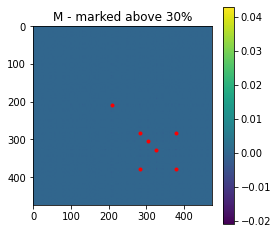

In [11]:
# display learned M
M = B.T @ B
# to preserve memory, uncomment below line
# del B

sg.display_matrix(M, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M) # marker threshold
f_sz = M.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M - marked above {}%'.format(thresh))
print('Coordinates of elements with higher values than {}'.format(lim))
print(list(zip(xloc[M > lim],yloc[M > lim])))

# save results
plt.savefig('../../data/experiments/slowfast/slowfast_sg/temp/finalM_'+str(0)+'.png')
# plt.close()
# np.savetxt('results/sg_finalB.csv', B, delimiter=',')

# Validate the similarity graph

In [12]:
# acc, y_est, t = sg.get_acc(B, train_dess_nrm, train_data['lbls'], val_dess_nrm, val_data['lbls'], Dv=0, Dvt=1, seed=0, show_edges=True)
val_acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], Dv=0, Dvt=2000, seed=0, show_edges=True)

edges between val. nodes:
 []
edges between val. and train. nodes:
 [(0, 9), (0, 7), (0, 8), (0, 5), (0, 6), (0, 0), (0, 1), (0, 3), (0, 4), (0, 2), (1, 9), (1, 5), (1, 7), (1, 8), (1, 6), (1, 1), (1, 0), (1, 4), (1, 2), (1, 3), (2, 7), (2, 9), (2, 8), (2, 6), (2, 5), (2, 4), (2, 3), (2, 1), (2, 2), (2, 0), (3, 5), (3, 6), (3, 9), (3, 8), (3, 7), (3, 1), (3, 0), (3, 3), (3, 2), (3, 4), (4, 8), (4, 5), (4, 6), (4, 7), (4, 9), (4, 2), (4, 4), (4, 1), (4, 3), (4, 0), (5, 9), (5, 5), (5, 6), (5, 7), (5, 8), (5, 3), (5, 4), (5, 2), (5, 0), (5, 1)]


In [13]:
print('val acc = {:.2f}%'.format(val_acc*100))
print('elapsed time = {:.2f} ms'.format(t*1000))
print('estimated val labels = ', 2*(y_est>0).astype(np.int32)-1)

# # save results
# np.savetxt('results/sg_val_acc.txt', np.array([acc]))
# np.savetxt('results/sg_y_est.csv', y_est, delimiter=',')

val acc = 83.33%
elapsed time = 2.99 ms
estimated val labels =  [ 1  1  1  1 -1 -1]


In [14]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes = val_loc[y_est > 0]

if sum(val_data['lbls']==1) == 0:
    missed = 0
else:
    missed = sum(np.logical_and(val_data['lbls']==1, y_est < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm = 0
else:
    false_alarm = sum(np.logical_and(val_data['lbls']==-1, y_est > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm*100))

Estimated spike time bins:  [0 1 2 3]
Real spike time bins:  [0 1 2]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 0.00%
False spikes (/all no-spike bins): 33.33%


# Keep only high valued entries in M

In [15]:
Mc = M.copy()
Mc[M < lim] = 0
print('number of high valued entries: ', sum(Mc.reshape(-1) != 0))

number of high valued entries:  7


## Validate model using only high valued entries of M

In [16]:
thresh = 30
val_acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], Dv=0, Dvt=2000,
                               selective=True, thresh=thresh, seed=0, show_edges=True)

edges between val. nodes:
 []
edges between val. and train. nodes:
 [(0, 9), (0, 7), (0, 8), (0, 5), (0, 6), (0, 0), (0, 1), (0, 3), (0, 4), (0, 2), (1, 9), (1, 5), (1, 7), (1, 8), (1, 6), (1, 1), (1, 0), (1, 4), (1, 2), (1, 3), (2, 7), (2, 9), (2, 8), (2, 6), (2, 5), (2, 4), (2, 3), (2, 1), (2, 2), (2, 0), (3, 5), (3, 6), (3, 9), (3, 8), (3, 7), (3, 1), (3, 0), (3, 3), (3, 2), (3, 4), (4, 8), (4, 5), (4, 6), (4, 7), (4, 9), (4, 2), (4, 4), (4, 1), (4, 3), (4, 0), (5, 9), (5, 5), (5, 6), (5, 7), (5, 8), (5, 3), (5, 4), (5, 2), (5, 0), (5, 1)]


In [17]:
print('val acc = {:.2f}%'.format(val_acc*100))
print('elapsed time = {:.2f} ms'.format(t*1000))
print('estimated val labels = ', 2*(y_est>0).astype(np.int32)-1)

val acc = 83.33%
elapsed time = 3.99 ms
estimated val labels =  [ 1  1 -1 -1 -1 -1]


In [18]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes = val_loc[y_est > 0]

if sum(val_data['lbls']==1) == 0:
    missed = 0
else:
    missed = sum(np.logical_and(val_data['lbls']==1, y_est < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm = 0
else:
    false_alarm = sum(np.logical_and(val_data['lbls']==-1, y_est > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm*100))

Estimated spike time bins:  [0 1]
Real spike time bins:  [0 1 2]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 33.33%
False spikes (/all no-spike bins): 0.00%


In [ ]:
# import importlib
# importlib.reload(sg)

## Save validation results

In [15]:
# prepare results file
with open('../../data/slowfast_results/sg_4732_res_1.txt', 'w') as file:    
    arr = ('{:^10} | {:^10} | {:^10} | {:^10} | {:^10} | {:^17} | {:^17} \n'\
           .format('i', 'train_num', 'val_num', 'min_acc(%)', 'val_acc(%)',\
                   'missed spks(%)', 'false alarms(%)'),'-'*101+'\n')
    file.writelines(arr)

# save the experiment's results
with open('../../data/slowfast_results/sg_4732_res_1.txt', 'a') as file:
    file.write('{:^10} | {:^10} | {:^10} | {:^10.2f} | {:^10.2f} | {:^17.2f} | {:^17.2f} \n'\
               .format(0, train_num, val_num, min_acc*100, val_acc*100, missed*100, false_alarm*100))

# Show statistics

Text(0.5, 1.0, 'Time spent to find a valid stepsize in each iteration')

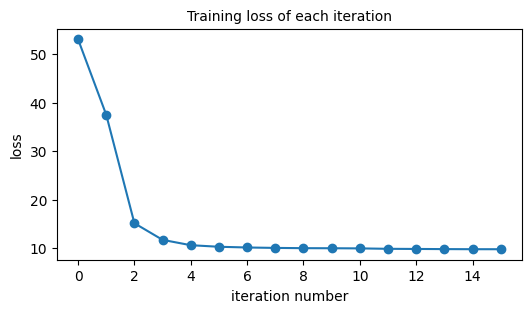

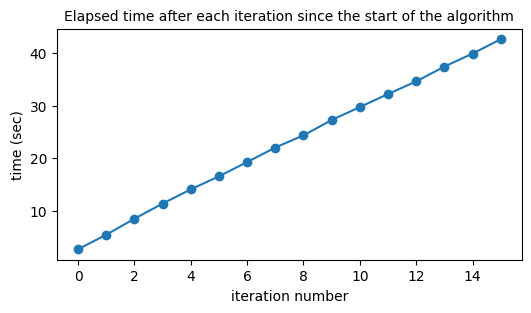

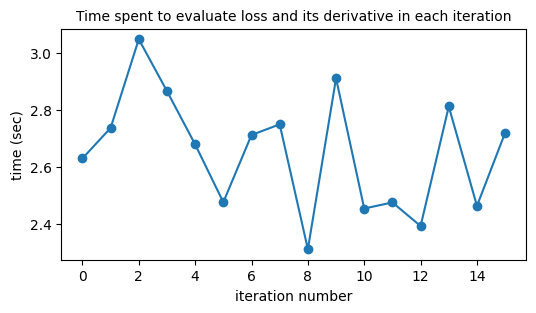

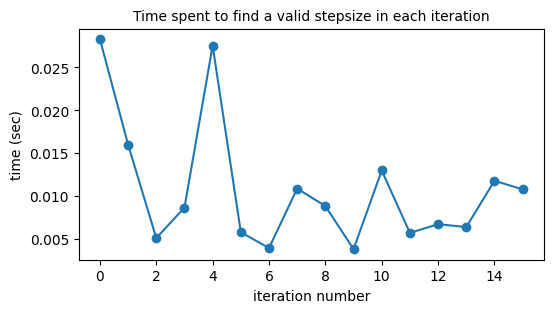

In [17]:
# Some informative figures to compare forced and flexible time complexity
plt.figure(figsize=(6,3))
plt.plot(sg_stats['train_losss'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('Training loss of each iteration', fontsize=10)
# plt.savefig('results/sg_trainlosss.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['it_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Elapsed time after each iteration since the start of the algorithm', fontsize=10)
# plt.savefig('results/sg_runtime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['eval_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to evaluate loss and its derivative in each iteration', fontsize=10)
# plt.savefig('results/sg_evallosstime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['stepsizeloop_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to find a valid stepsize in each iteration', fontsize=10)
# plt.savefig('results/sg_epsilontime.png')

M entries range from -0.02264 to 0.03710


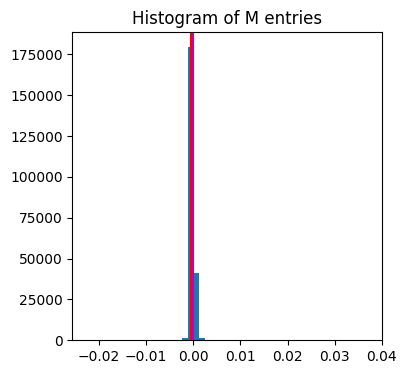

In [20]:
sg.hist_of_entries(M, 50, zeroline=True, peakline=True)
plt.title('Histogram of M entries')

print('M entries range from {:.5f} to {:.5f}'.format(np.min(M), np.max(M)))

# Select high valued entries

## Validate the model with sparse M

# Assess the graph model's performance and running time

In [21]:
# utility function to use with 'bn.assess' method
def get_sg_acc(train_data, val_data, sg_opt_params=sg_opt_params, D=1):
    """
    Fit similarity graph to training data and measure accuracy on validation set.
    NOTE: sg_opt_params, D are used from outside of the function.
    """
    B, stats = sg.fit_graph(train_data['des'], train_data['lbls'], \
                                      sg_opt_params, D=D, seed = None)

    acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], \
                               val_data['des'], val_data['lbls'])
    
    return acc

In [ ]:
sg_opt_params['print_checks'] = False
sg_portions = [0.02, 0.04, 0.06, 0.08, 0.10]
sg_rpts = [3]*len(sg_portions)

sg_nums, sg_accs, sg_times = bn.assess(get_slowfast_data, get_sg_acc, sg_portions, sg_rpts, show_msgs = True)

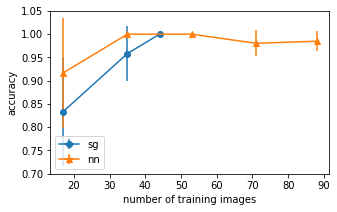

In [34]:
# plot accuracies obtained at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], sg_accs['val'], sg_accs['std'], sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], nn_accs['val'], nn_accs['std'], nn_nums['train_nums_std'], marker='^')
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.legend(['sg', 'nn'])
plt.title('Method performance for different dataset sizes')
plt.savefig('results/sg_performance.png')

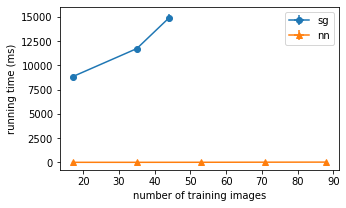

In [35]:
# plot model running times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], np.array(sg_times['run_t'])*1000, \
             np.array(sg_times['run_t_std'])*1000, sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['run_t'])*1000, \
             np.array(nn_times['run_t_std'])*1000, nn_nums['train_nums_std'], marker='^')
plt.xlabel('number of training images')
plt.ylabel('running time (ms)')
plt.legend(['sg', 'nn'])
plt.title('Method runtimes for different dataset sizes')
plt.savefig('results/sg_runtimes.png')

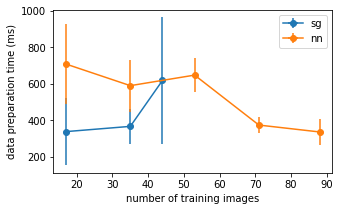

In [36]:
# plot data preparation times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], np.array(sg_times['data_t'])*1000, \
             np.array(sg_times['data_t_std'])*1000, sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['data_t'])*1000, \
             np.array(nn_times['data_t_std'])*1000, nn_nums['train_nums_std'], marker='o')
plt.xlabel('number of training images')
plt.ylabel('data preparation time (ms)')
plt.legend(['sg', 'nn'])
plt.title('Method preprocessing times for different sizes')
plt.savefig('results/sg_pretimes4sizes.png')